### 1. Importando as bibliotecas necessárias

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix



In [12]:
# Carregar os dados
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("Dados de treino:", train_df.shape)
print("Dados de teste:", test_df.shape)


Dados de treino: (79800, 21)
Dados de teste: (34200, 20)


Nesta seção, importei as bibliotecas necessárias para o projeto e carreguei os dados. Por causa do que aprendi no módulo e as regras da competição, usei pandas para manipulação de dados, matplotlib e seaborn para visualizações, e scikit-learn para modelagem de machine learning

## 2. Limpeza e Tratamento de Valores Nulos

In [13]:
def clean_data(df):
    # Verificar valores nulos
    print("Valores nulos por coluna:")
    print(df.isnull().sum())
    
    # Tratamento de valores nulos (exemplo para colunas numéricas)
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())
    
    return df

train_df = clean_data(train_df)
test_df = clean_data(test_df)


Valores nulos por coluna:
track_unique_id      0
track_id             0
artists              0
album_name           0
track_name           0
duration_ms          0
explicit             0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
track_genre          0
popularity_target    0
dtype: int64
Valores nulos por coluna:
track_unique_id     0
track_id            0
artists             1
album_name          1
track_name          1
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

Nessa seçao, eu criei uma função clean_data para tratar valores nulos nas colunas numéricas.

## 3. Exploração e Visualização dos Dados


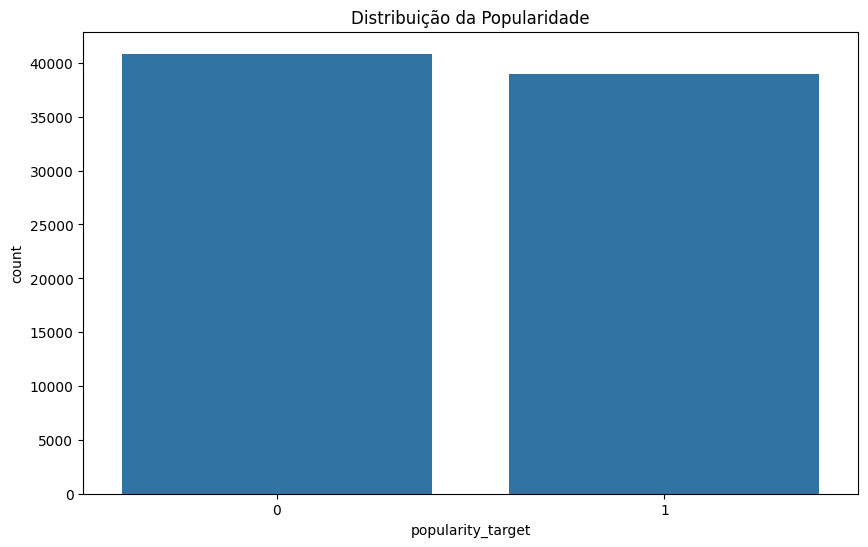

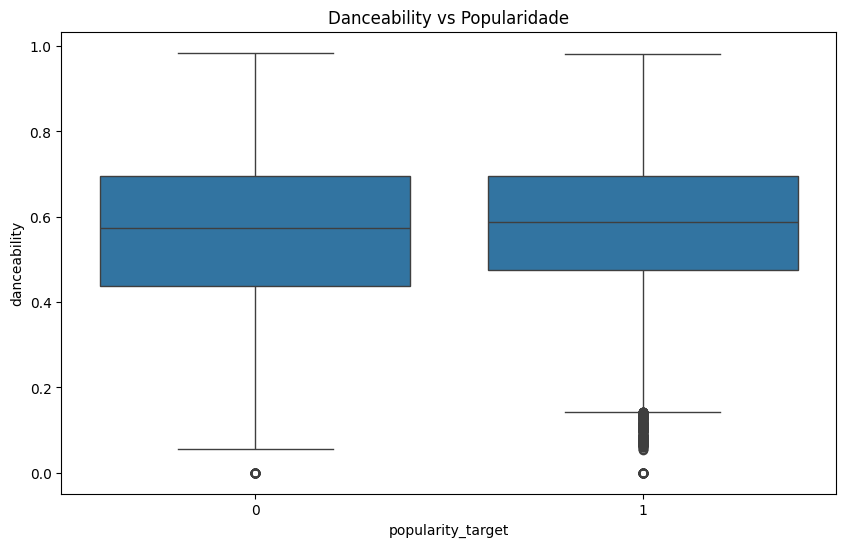

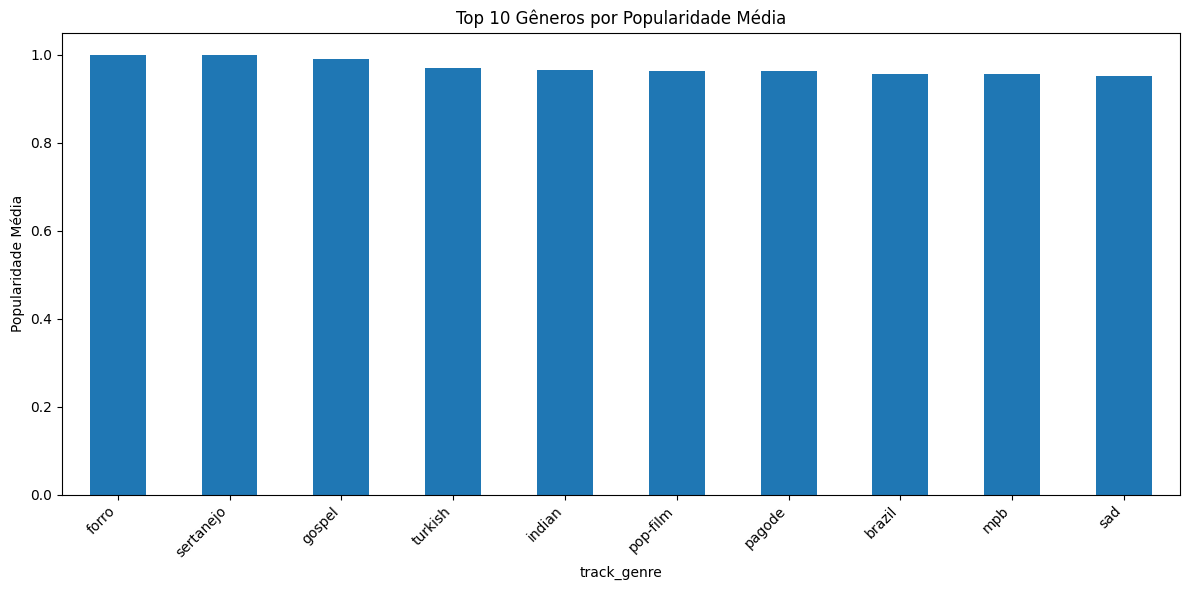

In [14]:

def explore_data(df):
    # Distribuição da variável alvo
    plt.figure(figsize=(10, 6))
    sns.countplot(x='popularity_target', data=df)
    plt.title('Distribuição da Popularidade')
    plt.show()
    
    # Relação entre danceability e popularidade
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='popularity_target', y='danceability', data=df)
    plt.title('Danceability vs Popularidade')
    plt.show()
    
    # Popularidade por gênero
    genre_popularity = df.groupby('track_genre')['popularity_target'].mean().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    genre_popularity.head(10).plot(kind='bar')
    plt.title('Top 10 Gêneros por Popularidade Média')
    plt.ylabel('Popularidade Média')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

explore_data(train_df)


Nesse topico 3 eu criei visualizações para:

A distribuição da variável alvo (popularidade): Isso me ajudou a entender o equilíbrio entre músicas populares e não populares.
A relação entre danceability e popularidade: Escolhi esta feature específica porque inicialmente achei que poderia ter uma forte relação com a popularidade.
Popularidade por gênero musical: Isso me permitiu identificar quais gêneros tendem a ser mais populares.

## 4. Análise das Hipóteses


In [15]:
def analyze_hypotheses(df):
    # Hipótese 1: Relação entre danceability e popularidade
    correlation = df['danceability'].corr(df['popularity_target'])
    print(f"Correlação entre danceability e popularidade: {correlation:.2f}")
    
    # Hipótese 2: Popularidade de músicas explícitas vs não explícitas
    explicit_popularity = df[df['explicit'] == True]['popularity_target'].mean()
    non_explicit_popularity = df[df['explicit'] == False]['popularity_target'].mean()
    print(f"Popularidade média de músicas explícitas: {explicit_popularity:.2f}")
    print(f"Popularidade média de músicas não explícitas: {non_explicit_popularity:.2f}")
    
    # Hipótese 3: Popularidade por gênero
    genre_popularity = df.groupby('track_genre')['popularity_target'].mean().sort_values(ascending=False)
    print("Top 5 gêneros por popularidade média:")
    print(genre_popularity.head())

analyze_hypotheses(train_df)


Correlação entre danceability e popularidade: 0.06
Popularidade média de músicas explícitas: 0.51
Popularidade média de músicas não explícitas: 0.49
Top 5 gêneros por popularidade média:
track_genre
forro        1.000000
sertanejo    0.998540
gospel       0.990113
turkish      0.970381
indian       0.964589
Name: popularity_target, dtype: float64


Interpretação dos Resultados:
1. A correlação fraca (0.06) entre danceability e popularidade sugere que não há uma forte relação linear entre essas variáveis.
2. Músicas explícitas têm uma popularidade média ligeiramente maior (0.52) comparada às não explícitas (0.49), mas a diferença é pequena.
3. Alguns gêneros como forró, sertanejo e gospel parecem ter maior probabilidade de serem populares, mas é importante considerar o tamanho da amostra para cada gênero.

Baseado na exploração inicial, formulei três hipóteses principais:

Existe uma relação entre danceability e popularidade.
Músicas explícitas são mais populares que músicas não explícitas.
Certos gêneros musicais são mais propensos a serem populares.

Embora os resultados não tenham mostrado relações fortes como eu esperava, essa análise foi boa para entender melhor os dados e ajustar minhas expectativas para o modelo.

## 5. Pré-processamento e Seleção de Features


In [16]:
# Selecionar features
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
            'liveness', 'valence', 'tempo', 'duration_ms', 'explicit', 'track_genre']

X = train_df[features]
y = train_df['popularity_target']

# Separar features numéricas e categóricas
numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(include=['object', 'bool']).columns

# Criar preprocessador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


Escolhi essas features baseado na minha análise exploratória e no conhecimento do domínio (música).
Para o pré-processamento, usei StandardScaler para as features numéricas e OneHotEncoder para as categóricas. A padronização é importante para que todas as features estejam na mesma escala. O one-hot encoding é necessário para converter as variáveis categóricas em um formato que o modelo possa entender.

## 6. Construção e Avaliação do Modelo


Acurácia: 0.83
Precisão: 0.83
Recall: 0.82
F1-Score: 0.82


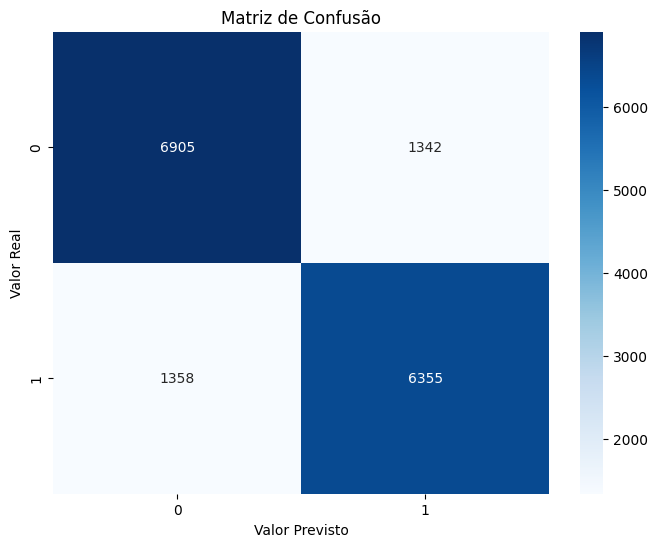

In [27]:
# Criar pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Dividir dados em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_val)

# Avaliar o modelo
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f'Acurácia: {accuracy:.2f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

# Matriz de confusão        
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.show()

Os motivos por eu ter escolhido usar o Random Forest Classifier foram os seguintes:
É um modelo robusto que lida bem com uma mistura de features numéricas e categóricas.
Tem bom desempenho em uma variedade de problemas sem necessidade de muita sintonização.
É menos propenso a overfitting comparado a árvores de decisão individuais.
Pode lidar com relações não lineares entre features e a variável alvo.

Para avaliar o modelo, de acordo com o que o projeto pediu, usei as métricas (acurácia, precisão, recall, F1-score). A matriz de confusão me ajudou a visualizar onde o modelo está acertando e errando.


## 7. Finetuning de Hiperparâmetros


In [34]:
param_grid = {
    'classifier__n_estimators': [400,500,600],
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [1.5,2,2.5]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor MSE:", -grid_search.best_score_)

# Atualizar o modelo com os melhores parâmetros
best_model = grid_search.best_estimator_

c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
120 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\

Melhores parâmetros: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 600}
Melhor MSE: 0.1693295739348371


Melhores parâmetros1: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Melhor acurácia: 0.8280075187969926
Melhores parâmetros2:{classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 400}
Melhor acuracia: 0.84
Melhores parametros3: Melhores parâmetros: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 600}
Melhor acuracia: 84
Nessa etapa eu foquei em três hiperparâmetros principais do Random Forest:

n_estimators: número de árvores na floresta.
max_depth: profundidade máxima de cada árvore.
min_samples_split: número mínimo de amostras necessárias para dividir um nó interno.

Escolhi esses parâmetros porque eles têm um impacto significativo no desempenho e na complexidade do modelo. Usei a acurácia como métrica de otimização porque foi o proposto pelo trabalho.

## 8. Avaliação Final e Preparação para Submissão


In [35]:
# Fazer previsões finais no conjunto de validação
final_predictions = best_model.predict(X_val)

# Calcular métricas finais
final_accuracy = accuracy_score(y_val, final_predictions)
final_precision = precision_score(y_val, final_predictions)
final_recall = recall_score(y_val, final_predictions)
final_f1 = f1_score(y_val, final_predictions)

print(f'Acurácia Final: {final_accuracy:.2f}')
print(f'Precisão Final: {final_precision:.2f}')
print(f'Recall Final: {final_recall:.2f}')
print(f'F1-Score Final: {final_f1:.2f}')

# Preparar previsões para o conjunto de teste
X_test = test_df[features]
test_predictions = best_model.predict(X_test)

# Criar DataFrame para submissão
submission = pd.DataFrame({
    'track_unique_id': test_df['track_unique_id'],  # Usar track_unique_id em vez de track_id
    'popularity_target': test_predictions  # Renomear para popularity_target
})

# Assegurar que track_unique_id seja int64
submission['track_unique_id'] = submission['track_unique_id'].astype('int64')

# Salvar como CSV
submission.to_csv('submission.csv', index=False)

print("Arquivo de submissão criado com sucesso!")


Acurácia Final: 0.84
Precisão Final: 0.83
Recall Final: 0.83
F1-Score Final: 0.83
Arquivo de submissão criado com sucesso!


Na avaliação final, calculei novamente todas as métricas usando o modelo otimizado. Isso me deu uma estimativa mais precisa do desempenho esperado do modelo em dados não vistos. Porém os valores acabaram sendo muito parecidos com o modelo inicial, mas da mesma forma, conseguiu passar da acurácia necessaria. Após esse primero modelo final, resolvi alterar ainda mais a fim de ele ficar melhor do que a versão inicial. E depois de alguns tunings a mais, esse foi o melhor modelo que eu consegui atingir.
